# Piecewise linear trends & changepoints

In this notebook we will show how to create features to capture changepoints by building a piecewise linear regression. We will use recursive forecasting to see how we can use this in practice!

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Create-Datasets" from this repo.

## Data Set Synopsis

The timeseries is between January 1992 and Apr 2005.

It consists of a single series of monthly values representing sales volumes. 

In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

sns.set_context("talk")

In [2]:
data = pd.read_csv(
    "../Datasets/example_retail_sales.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

In [3]:
# Set the index to monthly frequency
data = data.asfreq("MS")

# Convert from datetime to period
data.index = data.index.to_period()

# Plot time series

In [4]:
df = data.copy()

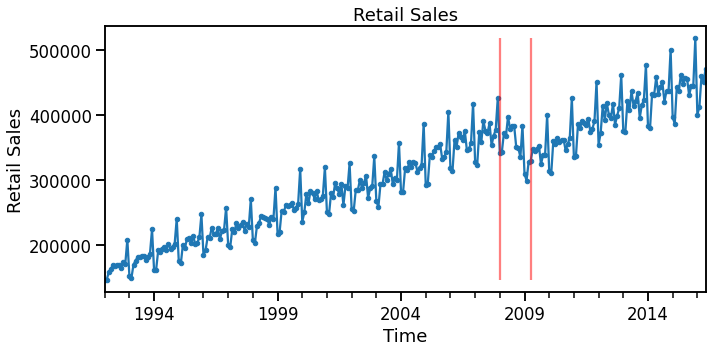

In [5]:
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_xlabel("Time")
ax.set_ylabel("Retail Sales")
ax.set_title("Retail Sales")
ax.vlines(["2008-01-01", "2009-04-01"], ymin=df["y"].min(), ymax=df["y"].max(), color='r', alpha=0.5)
plt.tight_layout()

# Creating the features with Pandas

In [6]:
changepoints = ["1992-01", # start of time series
                "2008-01", # changepoint
                "2009-04", # changepoint
               ] 

In [7]:
for changepoint in changepoints:
    changepoint_period = pd.Period(changepoint, freq="M")
    feat_name = f"time_since_{changepoint_period}"
    time_diff_period = df.index - changepoint_period
    # Convert time difference from period to int
    time_diff_int = time_diff_period.map(lambda x: x.n)
    df[feat_name] = time_diff_int
    df[feat_name] = df[feat_name].clip(lower=0)

In [8]:
time_diff_int

Int64Index([-207, -206, -205, -204, -203, -202, -201, -200, -199, -198,
            ...
              76,   77,   78,   79,   80,   81,   82,   83,   84,   85],
           dtype='int64', name='ds', length=293)

In [9]:
df.loc[changepoint_period-3:changepoint_period+3]

,y,time_since_1992-01,time_since_2008-01,time_since_2009-04
ds,,,,
2009-01,310269,204,12,0
2009-02,299488,205,13,0
2009-03,328568,206,14,0
2009-04,329866,207,15,0
2009-05,347768,208,16,1
2009-06,344439,209,17,2
2009-07,348106,210,18,3


# Creating the features with sktime 

In [10]:
from sktime.transformations.series.time_since import TimeSince

Manually specify the changepoints.

In [11]:
# Specify changepoints in monthly period
changepoints = ["1992-01", # start of time series
                "2008-01", # changepoint
                "2009-04", # changepoint
               ] 

Use the `TimeSince` transformer to create the changepoint features.

In [12]:
time_since_transformer = TimeSince(start=changepoints, 
                                   positive_only=True, 
                                   keep_original_columns=True)

time_since_transformer.fit_transform(df)

,y,time_since_1992-01,time_since_2008-01,time_since_2009-04
ds,,,,
1992-01,146376,0,0,0
1992-02,147079,1,0,0
1992-03,159336,2,0,0
1992-04,163669,3,0,0
1992-05,170068,4,0,0
...,...,...,...,...
2016-01,400928,288,96,81
2016-02,413554,289,97,82
2016-03,460093,290,98,83


# Let's build a forecast!

Let's build a recursive forecast and see how our changepoint features can help!

In [13]:
from sktime.transformations.series.summarize import WindowSummarizer


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [14]:
df = data.copy()
df.head()

,y
ds,
1992-01,146376
1992-02,147079
1992-03,159336
1992-04,163669
1992-05,170068


In [15]:
# Compute features for piecewise regression
# which helps us handle changepoints.
changepoints = ["1992-01", # start of time series
                "2008-01", # changepoint
                "2009-04", # changepoint
               ] 

time_since_transformer = TimeSince(changepoints, positive_only=True)
time_since_transformer.fit_transform(df)

,time_since_1992-01,time_since_2008-01,time_since_2009-04
ds,,,
1992-01,0,0,0
1992-02,1,0,0
1992-03,2,0,0
1992-04,3,0,0
1992-05,4,0,0
...,...,...,...
2016-01,288,96,81
2016-02,289,97,82
2016-03,290,98,83


In [16]:
# Features computed from the target.
# Compute lag and window features.
lag_window_transformer = WindowSummarizer(
    lag_feature={
        "lag": [1],  # Lag features.
        # "mean": [[1, 12]],  # [[lag, window size]]
    },
    truncate="bfill", # Backfill missing values from lagging and windowing.
    )

In [27]:
lag_window_transformer.fit_transform(df[["y"]])

,y_lag_1
ds,
1992-01,146376.0
1992-02,146376.0
1992-03,147079.0
1992-04,159336.0
1992-05,163669.0
...,...
2016-01,518253.0
2016-02,400928.0
2016-03,413554.0


In [28]:
# --- CONFIG --- #
# Define time of first forecast, this determines our train / test split                                                    
forecast_start_period = pd.Period("1958-01", freq="M")
# Define number of steps to forecast.
num_of_forecast_steps = 60
# Define the target variable in our data.
target = "y"
# Define the model.
model = Pipeline(steps=[
                        ('scaler', MinMaxScaler()), 
                        ('model', LinearRegression()),
])

# Set flag which will determine if model is fit once.
fit_once = True # if True fit model once.
                # if False fit model on each iteration.

# --- CREATE DYNAMIC TRAINING DATAFRAME  --- #
# `df_train` is "dynamic" because we will dynamically append 
# the features built from the target to this dataframe. 
# It's "training" because we use this dataframe 
# to create the training set passed to the model.
forecast_periods = pd.period_range(forecast_start_period, 
                                   periods=num_of_forecast_steps,
                                   freq="M")

# Ensure we only have training data up to the start
# of the forecast.
df_train = df.loc[:forecast_start_period].copy()

# Extend index to include the forecasting horizon.
# The target variable will be NaN in the forecasting horizon
# at this stage. As we iteratively make forecasts we will fill
# the missing values with forecasts.
df_train = pd.concat([
                      df_train,
                      pd.DataFrame(index=forecast_periods)
                     ], 
                     axis=1)

# --- FEATURE ENGINEERING FOR FUTURE KNOWN FEATURES --- #
# Here, we create any features where we already know 
# the feature value in the forecast horizon (i.e., the future).
# Hence, we can compute them just once and outside of the
# recursive forecasting loop that will follow.

# Create features from date and time.
X_time_features = time_since_transformer.fit_transform(df_train)


# --- RECURSIVE FORECASTING LOOP --- #
_model_is_not_fitted = True
for forecast_period in forecast_periods:    
    # --- FEATURE ENGINEERING FROM TARGET --- #
    # Create lag & window features.
    X_target_features = lag_window_transformer.fit_transform(df_train[[target]])

    # --- CREATE TRAIN AND TEST (PREDICT) SET --- #
    # Join the features onto the target, this  makes it easy to
    # inspect the features and target manually.
    df_y_and_X = pd.concat([
                            df_train[target], 
                            X_time_features, 
                            X_target_features,
                           ], axis=1)
    
    
    # Get feature names.
    features = df_y_and_X.columns.drop(labels=target)
    
    # Filter on forecast period to get training set.
    train_mask = df_y_and_X.index < forecast_period
    X_train = df_y_and_X.loc[train_mask, features]
    y_train = df_y_and_X.loc[train_mask, target]
    
    # Filter on forecast date to get test set (predict set). 
    # We're forecasting one step ahead at a time,
    # so there is only one row in X_test!
    X_test = df_y_and_X.loc[[forecast_period], features]

    # --- MAKE FORECAST --- #
    # Train a model. 
    #
    # If `fit_once` is True then the model
    # is trained only once, on the first
    # iteration, and then never again.
    #
    # If `fit_once` is False then the model 
    # is trained on the dyanmically expanding
    # training dataframe on each iteration.
    if fit_once and _model_is_not_fitted:
        model.fit(X_train, y_train)
        _model_is_not_fitted = False
    elif fit_once is False:
        model.fit(X_train, y_train)
    
    # Predict one step ahead. 
    y_pred = model.predict(X_test)
    
    # Append forecast to the target variable columnn in our
    # dynamic training dataframe `df_train`. This `df_train`
    # is ready for the next iteration where we will re-compute
    # features derived from the target.
    df_train.loc[forecast_period, target] = y_pred[0]

In [29]:
# --- CREATE IN-SAMPLE PREDICTIONS--- #
# Look at predictions on the training set 
# using the one step ahead forecast model.
train_mask = df_y_and_X.index < forecast_start_period
X_train = df_y_and_X.loc[train_mask, features]
y_forecast_train = model.predict(X_train)
y_forecast_train = pd.DataFrame({"y":y_forecast_train.flatten()}, index=X_train.index)

In [20]:
# --- CONVENIENT POST PROCESSING--- #
# Fill in last forecast in the dataframe that contains
# target and features.
df_y_and_X.loc[forecast_period, target] = y_pred[0]

# Retreive forecast and actuals.
y_forecast = df_train.loc[forecast_start_period:, target]
y_train = df.loc[:forecast_start_period, target]
y_test = df.loc[forecast_start_period:, target]

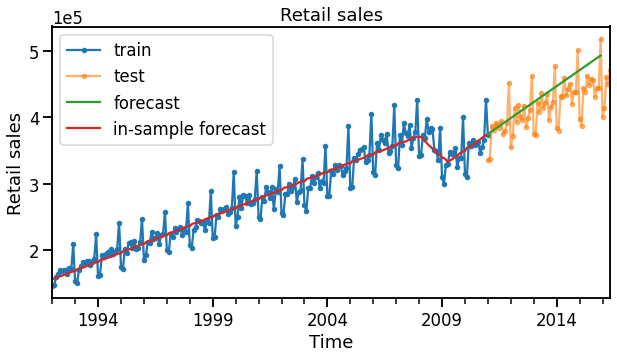

In [26]:
# Plot the forecast.
fig, ax = plt.subplots(figsize=[10, 5])

# Plot training set.
y_train[:forecast_start_period].plot(ax=ax, marker='.')
# Plot actuals in forecasting horizon.
y_test.plot(ax=ax, marker='.', alpha=0.6)
# Plot forecast.
y_forecast.plot(ax=ax)
# Plot 1 step forecasts in training data.
y_forecast_train.plot(ax=ax)

ax.legend(["train", "test", "forecast", "in-sample forecast"])
ax.set_xlabel("Time")
ax.set_ylabel("Retail sales")
ax.set_title("Retail sales")
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

In [ ]:
# Compute error metrics.
from sklearn.metrics import mean_squared_error
mean_squared_error(y_forecast, y_test.loc[y_forecast.index], squared=False)

We can now implement a piecewise linear trend to deal with changepoints alongside other features in a recursive forecasting workflow. We can see that the changepoint features can help capture changes in trend in the data when using linear models.

Feel free to change the dates, try different models, and different features!